In [ ]:
!pip install split_folders

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random
import splitfolders
import os
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Definisikan direktori dataset
train_dir = '/content/drive/MyDrive/Skin_Disease/TRAIN'
test_dir = '/content/drive/MyDrive/Skin_Disease/TEST'

In [ ]:
# Fungsi untuk menghitung jumlah sampel dalam setiap kelas
def count_samples(directory):
    count = {}
    for subdir in os.listdir(directory):
        class_dir = os.path.join(directory, subdir)
        if os.path.isdir(class_dir):
            count[subdir] = len(os.listdir(class_dir))
    return count

# Hitung jumlah sampel dalam setiap kelas untuk data train dan test
train_counts = count_samples(train_dir)
test_counts = count_samples(test_dir)

# Cetak jumlah sampel dalam setiap kelas
print("Train counts:", train_counts)
print("Test counts:", test_counts)


Train counts: {'Dermatitis': 80, 'Melanocytic': 80, 'Eczema': 80, 'Basal Cell': 80, 'Melanoma': 80}
Test counts: {'Dermatitis': 20, 'Eczema': 20, 'Melanocytic': 20, 'Basal Cell': 20, 'Melanoma': 20}


In [ ]:
# Tentukan direktori output untuk menyimpan dataset yang dibagi
output_dir = '/content/drive/MyDrive/Skin_Disease/split_data'

# Bagi dataset menjadi train, val, dan test
splitfolders.ratio(train_dir, output=output_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None)

# Definisikan direktori baru untuk train, val, dan test setelah pembagian
train_dir = '/content/drive/MyDrive/Skin_Disease/split_data/train'
val_dir = '/content/drive/MyDrive/Skin_Disease/split_data/val'
test_dir = '/content/drive/MyDrive/Skin_Disease/split_data/test'

# Hitung jumlah sampel dalam setiap kelas untuk setiap set
train_counts = count_samples(train_dir)
val_counts = count_samples(val_dir)
test_counts = count_samples(test_dir)

# Cetak jumlah sampel dalam setiap kelas untuk setiap set
print("Train counts:", train_counts)
print("Validation counts:", val_counts)
print("Test counts:", test_counts)

Copying files: 400 files [00:10, 37.40 files/s]


Train counts: {'Dermatitis': 64, 'Melanocytic': 64, 'Eczema': 64, 'Basal Cell': 64, 'Melanoma': 64}
Validation counts: {'Dermatitis': 8, 'Melanocytic': 8, 'Eczema': 8, 'Basal Cell': 8, 'Melanoma': 8}
Test counts: {'Dermatitis': 8, 'Melanocytic': 8, 'Eczema': 8, 'Basal Cell': 8, 'Melanoma': 8}


In [ ]:
# Fungsi untuk menampilkan gambar acak dari suatu kelas
def random_image(directory, class_name):
    folder = os.path.join(directory, class_name)
    if not os.path.exists(folder):
        print(f"Directory {folder} not found.")
        return None
    random_image_file = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, random_image_file)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')  # Sembunyikan sumbu untuk tampilan gambar yang lebih baik
    return img

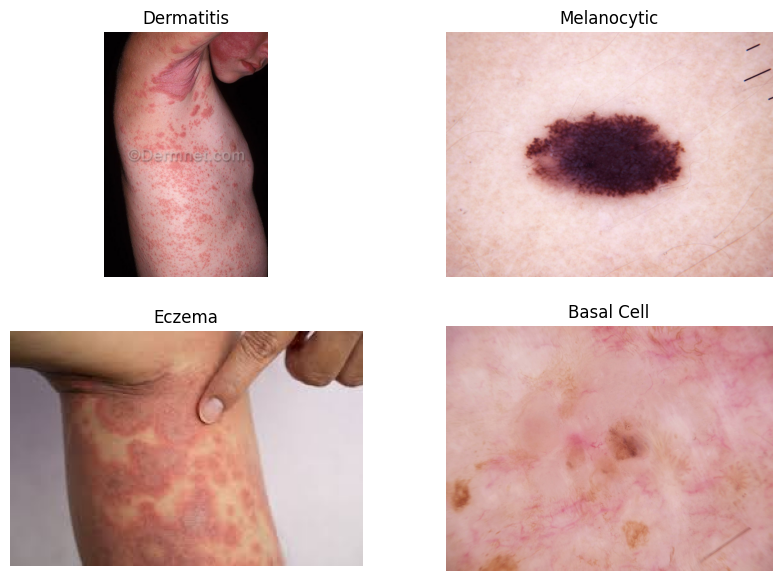

In [ ]:
import matplotlib.image as mpimg

# Buat subplot untuk menampilkan gambar acak dari setiap kelas val
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
random_image(val_dir, "Dermatitis")
fig.add_subplot(2, 2, 2)
random_image(val_dir, "Melanocytic")
fig.add_subplot(2, 2, 3)
random_image(val_dir, "Eczema")
fig.add_subplot(2, 2, 4)
random_image(val_dir, "Basal Cell")
plt.show()

In [ ]:
# Buat dataset menggunakan image_dataset_from_directory
train_data = image_dataset_from_directory(train_dir, label_mode='int', image_size=(224,224), batch_size=32, shuffle=True, seed=42)
test_data = image_dataset_from_directory(test_dir, label_mode='int', image_size=(224,224), batch_size=32, shuffle=False, seed=42)
val_data = image_dataset_from_directory(val_dir, label_mode='int', image_size=(224,224), batch_size=32, shuffle=False, seed=42)

Found 320 files belonging to 5 classes.
Found 40 files belonging to 5 classes.
Found 40 files belonging to 5 classes.


In [ ]:
# Augmentasi data
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal")
], name="data_augmentation_layer")

# Definisikan model Anda
input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape)

# Terapkan augmentasi data ke input
augmented_inputs = data_aug(inputs)

# Gunakan augmented_inputs sebagai input untuk model Anda
x = layers.Conv2D(64, (3, 3), activation='relu')(augmented_inputs)
x = layers.GlobalAvgPool2D(name="pooling_layer")(x)
x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(5)(x)  # Ubah jumlah unit menjadi 5 sesuai jumlah kelas
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

In [ ]:
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks untuk pelatihan
early_stop = EarlyStopping(monitor='val_loss', patience=6, min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-7)

In [ ]:
# Latih model Anda
history_1 = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[early_stop, reduce_lr])

Epoch 1/20
10/10 [==============================] - 23s 2s/step - loss: 16.0764 - accuracy: 0.2000 - val_loss: 8.9737 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 21s 2s/step - loss: 5.2800 - accuracy: 0.1906 - val_loss: 2.8600 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 21s 2s/step - loss: 2.3781 - accuracy: 0.3094 - val_loss: 2.0978 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 19s 2s/step - loss: 2.0696 - accuracy: 0.3562 - val_loss: 2.5849 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 19s 2s/step - loss: 1.9416 - accuracy: 0.4062 - val_loss: 1.5947 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - 20s 2s/step - loss: 1.6221 - accuracy: 0.3781 - val_loss: 1.6517 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - 34s 3s/step - loss: 1.5643 - 

In [ ]:
print("Testing Accuracy",model.evaluate(test_data))

2/2 [==============================] - 2s 135ms/step - loss: 1.2135 - accuracy: 0.5750
Testing Accuracy [1.2135390043258667, 0.574999988079071]
